###import and dataset


**Install requirements**

In [ ]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [ ]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

**Define Data Preprocessing**

In [ ]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),    
                                      transforms.CenterCrop(224),   
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) 
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))                                    
])

**Download Dataset**

In [ ]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS.git

In [ ]:
photo_dir = 'Homework3-PACS/PACS/photo'
art_dir = 'Homework3-PACS/PACS/art_painting'
cartoon_dir = 'Homework3-PACS/PACS/cartoon'
sketch_dir = 'Homework3-PACS/PACS/sketch'
BATCH_SIZE = 256
# Prepare Pytorch train/test Datasets
photo_dataset = torchvision.datasets.ImageFolder(photo_dir, transform=train_transform)
art_dataset = torchvision.datasets.ImageFolder(art_dir, transform=eval_transform)
cartoon_dataset = torchvision.datasets.ImageFolder(cartoon_dir, transform=train_transform)
sketch_dataset = torchvision.datasets.ImageFolder(sketch_dir, transform=eval_transform)

photo_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
art_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
cartoon_dataloader = DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
sketch_dataloader = DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
photo = [0,0,0,0,0,0,0]
art = [0,0,0,0,0,0,0]
cartoon = [0,0,0,0,0,0,0]
sketch = [0,0,0,0,0,0,0]

for images, label in photo_dataloader:
  for i in label:
    photo[i] += 1

for images, label in art_dataloader:
  for i in label:
    art[i] += 1

for images, label in cartoon_dataloader:
  for i in label:
    cartoon[i] += 1

for images, label in sketch_dataloader:
  for i in label:
    sketch[i] += 1


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


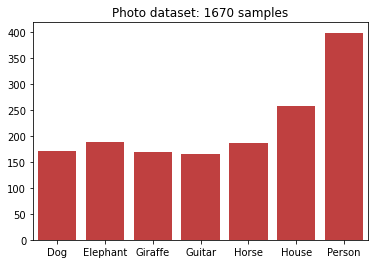

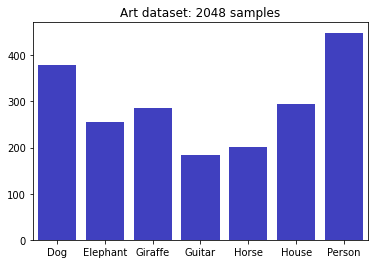

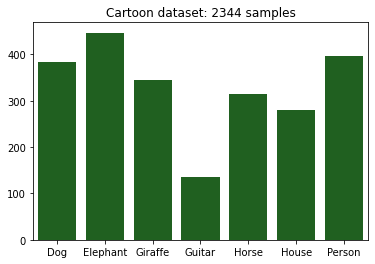

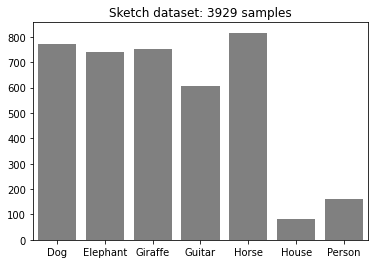

Photo dataset: 1670 samples
Art dataset: 2048 samples
Cartoon dataset: 2344 samples
Sketch dataset: 3929 samples
PACS dataset: 9991 samples


In [ ]:
classes = ["Dog", "Elephant", "Giraffe", "Guitar", "Horse", "House", "Person"]

ax = sns.barplot(x = classes, y = photo, color= "red", saturation=0.5)
plt.title('Photo dataset: {} samples'.format(len(photo_dataset)))
plt.savefig("photo")
plt.show()

ax = sns.barplot(x = classes, y = art, color= "blue", saturation=0.5)
plt.title('Art dataset: {} samples'.format(len(art_dataset)))
plt.savefig("art")
plt.show()

ax = sns.barplot(x = classes, y = cartoon, color= "green", saturation=0.5)
plt.title('Cartoon dataset: {} samples'.format(len(cartoon_dataset)))
plt.savefig("cartoon")
plt.show()

ax = sns.barplot(x = classes, y = sketch, color= "gray", saturation=0.5)
plt.title('Sketch dataset: {} samples'.format(len(sketch_dataset)))
plt.savefig("sketch")
plt.show()

print('Photo dataset: {} samples'.format(len(photo_dataset)))
print('Art dataset: {} samples'.format(len(art_dataset)))
print('Cartoon dataset: {} samples'.format(len(cartoon_dataset)))
print('Sketch dataset: {} samples'.format(len(sketch_dataset)))
print('PACS dataset: {} samples'.format(len(art_dataset)+len(photo_dataset)+len(sketch_dataset)+len(cartoon_dataset)))

**Validation function**

In [ ]:
#one dataset
def validation(net, dataloader, lenght): 
  net = net.to(DEVICE) 
  net.train(False) 

  running_corrects = 0
  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = net(images)
    _, preds = torch.max(outputs.data, 1)

    running_corrects += torch.sum(preds == labels.data).data.item()

  accuracy = running_corrects / float(lenght)
  print(accuracy)

In [ ]:
#2 dataset
def multi_validation(net, dataloader1, dataloader2, lenght): 
  net = net.to(DEVICE) 
  net.train(False) 

  running_corrects = 0
  for images, labels in tqdm(dataloader1):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = net(images)
    _, preds = torch.max(outputs.data, 1)

    running_corrects += torch.sum(preds == labels.data).data.item()

  for images, labels in tqdm(dataloader2):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    outputs = net(images)
    _, preds = torch.max(outputs.data, 1)

    running_corrects += torch.sum(preds == labels.data).data.item()

  accuracy = running_corrects / float(lenght)
  print(accuracy)

###The Model

In [ ]:
import torch.nn as nn
from torch.autograd import Function


class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

#set the flag to disciminate the input
class RandomNetworkWithReverseGrad(nn.Module):
    def __init__(self, **kwargs):
        super(RandomNetworkWithReverseGrad, self).__init__()
        #alexnet fetures extractor
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),)

        #alexnet classifier (fully connected layers)
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1000),) 

        #alexnet classifier (fully connected layers)
        self.dann_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2),)  

    def forward(self, x, alpha=None):
        # If we pass alpha, we can assume we are training the discriminator
        if alpha is not None:
            # gradient reversal layer (backward gradients will be reversed) #multiply by alpha
            x = self.features(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = ReverseLayerF.apply(x, alpha)   #reverse_feature
            x = self.dann_classifier(x)
            return x   
        else: # If we don't pass alpha, we assume we are training with supervision
            x = self.features(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.classifier(x)
            return x

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.utils import load_state_dict_from_url

model_urls = {'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',}

def DANNnet(**kwargs):
    model = RandomNetworkWithReverseGrad(**kwargs)

    state_dict = load_state_dict_from_url(model_urls['alexnet'], progress=True)
    model.load_state_dict(state_dict, strict=False) 
    for i in [1,4,6]:
      model.dann_classifier[i].weight.data = model.classiﬁer[i].weight.data
      model.dann_classifier[i].bias.data = model.classiﬁer[i].bias.data
    model.classifier[6] = nn.Linear(4096, 7)
    return model

###Without adaptation 

**Set Arguments**

In [ ]:
DEVICE = 'cuda'
NUM_CLASSES = 7 
BATCH_SIZE = 256    
LR = 0.01          
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 30      
STEP_SIZE = 20       
GAMMA = 0.1          
LOG_FREQUENCY = 10

**Prepare Dataset - Dataloaders**

In [ ]:
train_dir = 'Homework3-PACS/PACS/photo'
test_dir = 'Homework3-PACS/PACS/art_painting'

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=eval_transform)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

**Prepare Network - Training**

In [ ]:
net = DANNnet()

criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [ ]:
net = net.to(DEVICE) 
cudnn.benchmark 
current_step = 0

for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))

  for images, labels in train_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train()
    optimizer.zero_grad() 
    outputs = net(images)
    loss = criterion(outputs, labels)

    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    loss.backward()
    optimizer.step()
    current_step +=1

  scheduler.step() 

**Test**

In [ ]:
net = net.to(DEVICE) 
net.train(False) 

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  outputs = net(images)
  _, preds = torch.max(outputs.data, 1)

  running_corrects += torch.sum(preds == labels.data).data.item()

accuracy = running_corrects / float(len(test_dataset))
print('Test Accuracy: {}'.format(accuracy))

###With adaptation

**Set Arguments**

In [ ]:
DEVICE = 'cuda'
NUM_CLASSES = 7 
BATCH_SIZE = 256    
LR = 0.01        
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 20      
STEP_SIZE = 20       
GAMMA = 0.1          
LOG_FREQUENCY = 10
ALPHA = 0.001

**Prepare Dataloaders**

In [ ]:
train_dir = 'Homework3-PACS/PACS/photo'
test_dir = 'Homework3-PACS/PACS/art_painting'

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(test_dir, transform=eval_transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

**Prepare Network - Training**

In [ ]:
net = DANNnet()
criterion_class = nn.CrossEntropyLoss() 
criterion_domain = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [ ]:
net = net.to(DEVICE) 
cudnn.benchmark 
current_step = 0

ones = torch.ones(BATCH_SIZE).long()
zeros = torch.zeros(BATCH_SIZE).long()

N = max(len(train_dataloader),len(test_dataloader))

for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
  train_iterator = iter(train_dataloader)
  test_iterator = iter(test_dataloader)
  for i in range(N):

    optimizer.zero_grad()
    net.train()
    #train data on Gy
    try:
      images, labels = next(train_iterator)
    except StopIteration:
      train_iterator = iter(train_dataloader)
      images, labels = next(train_iterator)

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    outputs = net(images)
    loss_class = criterion_class(outputs, labels)
    loss_class.backward()
  
    # train data on gd
    images = images.to(DEVICE)
    labels = zeros.to(DEVICE)
    outputs = net(images, alpha = ALPHA)
    loss_domain = criterion_domain(outputs, labels)
    loss_domain.backward()

    #test data on the Gd
    try:
      images, labels = next(test_iterator)
    except StopIteration:
      test_iterator = iter(test_dataloader)
      images, labels = next(test_iterator)
    images = images.to(DEVICE)
    labels = ones.to(DEVICE)
    outputs = net(images, alpha = ALPHA)
    loss_domain = criterion_domain(outputs, labels)
    loss_domain.backward()

    current_step += 1
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss_class.item()))
    optimizer.step() 

  scheduler.step() 

**Test**

In [ ]:
net = net.to(DEVICE) 
net.train(False) 

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)
  outputs = net(images)
  _, preds = torch.max(outputs.data, 1)
  running_corrects += torch.sum(preds == labels.data).data.item()

accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

###Cross Domain Validation

####4A (without adaptation)

**Set Arguments**

In [ ]:
DEVICE = 'cuda'
NUM_CLASSES = 7 
BATCH_SIZE = 256    
LR = 0.005          #0.1, 0.01, 0.001
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 51      #10, 30, 50
STEP_SIZE = 20       
GAMMA = 0.1          
LOG_FREQUENCY = 10

**Prepare Dataset - Dataloader**

In [ ]:
photo_dir = 'Homework3-PACS/PACS/photo'
art_dir = 'Homework3-PACS/PACS/art_painting'
cartoon_dir = 'Homework3-PACS/PACS/cartoon'
sketch_dir = 'Homework3-PACS/PACS/sketch'

# Prepare Pytorch train/test Datasets
photo_dataset = torchvision.datasets.ImageFolder(photo_dir, transform=train_transform)
art_dataset = torchvision.datasets.ImageFolder(art_dir, transform=eval_transform)
cartoon_dataset = torchvision.datasets.ImageFolder(cartoon_dir, transform=train_transform)
sketch_dataset = torchvision.datasets.ImageFolder(sketch_dir, transform=eval_transform)

photo_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
art_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
cartoon_dataloader = DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
sketch_dataloader = DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

**Prepare Network - Training**

In [ ]:
net = DANNnet()
criterion = nn.CrossEntropyLoss() 
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train (on photo)**

In [ ]:
net = net.to(DEVICE) 
cudnn.benchmark 
current_step = 0
c = 0

for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
  
  if c % LOG_FREQUENCY == 0:
    print('Epoch: {}'.format(epoch))
    print("Accuracy on cartoon:")
    validation(net, cartoon_dataloader, len(cartoon_dataset)) 

    print("Accuracy on sketch:")
    validation(net, sketch_dataloader, len(sketch_dataset)) 
  c += 1

  for images, labels in photo_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train()
    optimizer.zero_grad() 
    outputs = net(images)
    loss = criterion(outputs, labels)

    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    loss.backward()
    optimizer.step()
    current_step +=1

  scheduler.step() 

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/9 [00:00<?, ?it/s]

Starting epoch 1/51, LR = [0.005]
Epoch: 0
Accuracy on cartoon:


  0%|          | 0/16 [00:00<?, ?it/s]

0.10580204778156997
Accuracy on sketch:


100%|██████████| 16/16 [00:16<00:00,  1.03s/it]

0.16110969712395012


Step 0, Loss 2.1299147605895996
Starting epoch 2/51, LR = [0.005]
Step 10, Loss 0.15202847123146057
Starting epoch 3/51, LR = [0.005]
Starting epoch 4/51, LR = [0.005]
Step 20, Loss 0.10247382521629333
Starting epoch 5/51, LR = [0.005]
Starting epoch 6/51, LR = [0.005]
Step 30, Loss 0.014771480113267899
Starting epoch 7/51, LR = [0.005]
Step 40, Loss 0.01655840501189232
Starting epoch 8/51, LR = [0.005]
Starting epoch 9/51, LR = [0.005]
Step 50, Loss 0.004358330741524696
Starting epoch 10/51, LR = [0.005]


  0%|          | 0/9 [00:00<?, ?it/s]

Starting epoch 11/51, LR = [0.005]
Epoch: 10
Accuracy on cartoon:


  0%|          | 0/16 [00:00<?, ?it/s]

0.24573378839590443
Accuracy on sketch:


100%|██████████| 16/16 [00:16<00:00,  1.02s/it]

0.28302367014507507


Step 60, Loss 0.0020088013261556625
Starting epoch 12/51, LR = [0.005]
Step 70, Loss 0.0024625416845083237
Starting epoch 13/51, LR = [0.005]
Starting epoch 14/51, LR = [0.005]
Step 80, Loss 0.0013611316680908203
Starting epoch 15/51, LR = [0.005]
Starting epoch 16/51, LR = [0.005]
Step 90, Loss 0.003117293119430542
Starting epoch 17/51, LR = [0.005]
Step 100, Loss 0.0015999246388673782
Starting epoch 18/51, LR = [0.005]
Starting epoch 19/51, LR = [0.005]
Step 110, Loss 0.00513845682144165
Starting epoch 20/51, LR = [0.005]


  0%|          | 0/9 [00:00<?, ?it/s]

Starting epoch 21/51, LR = [5e-05]
Epoch: 20
Accuracy on cartoon:


  0%|          | 0/16 [00:00<?, ?it/s]

0.2589590443686007
Accuracy on sketch:


100%|██████████| 16/16 [00:16<00:00,  1.03s/it]

0.30440315601934337


Step 120, Loss 0.0006030891090631485
Starting epoch 22/51, LR = [0.0005]
Step 130, Loss 0.00105266273021698
Starting epoch 23/51, LR = [0.0005]
Starting epoch 24/51, LR = [0.0005]
Step 140, Loss 0.0009367875754833221
Starting epoch 25/51, LR = [0.0005]
Starting epoch 26/51, LR = [0.0005]
Step 150, Loss 0.0007414184510707855
Starting epoch 27/51, LR = [0.0005]
Step 160, Loss 0.0007512569427490234
Starting epoch 28/51, LR = [0.0005]
Starting epoch 29/51, LR = [0.0005]
Step 170, Loss 0.0003196224570274353
Starting epoch 30/51, LR = [0.0005]


  0%|          | 0/9 [00:00<?, ?it/s]

Starting epoch 31/51, LR = [0.0005]
Epoch: 30
Accuracy on cartoon:


  0%|          | 0/16 [00:00<?, ?it/s]

0.2627986348122867
Accuracy on sketch:


100%|██████████| 16/16 [00:16<00:00,  1.05s/it]

0.30745736828709597


Step 180, Loss 0.0014058388769626617
Starting epoch 32/51, LR = [0.0005]
Step 190, Loss 0.0008142068982124329
Starting epoch 33/51, LR = [0.0005]
Starting epoch 34/51, LR = [0.0005]
Step 200, Loss 0.001434527337551117
Starting epoch 35/51, LR = [0.0005]
Starting epoch 36/51, LR = [0.0005]
Step 210, Loss 0.0012429673224687576
Starting epoch 37/51, LR = [0.0005]
Step 220, Loss 0.0006825905293226242
Starting epoch 38/51, LR = [0.0005]
Starting epoch 39/51, LR = [0.0005]
Step 230, Loss 0.0008573532104492188
Starting epoch 40/51, LR = [0.0005]


  0%|          | 0/9 [00:00<?, ?it/s]

Starting epoch 41/51, LR = [5e-06]
Epoch: 40
Accuracy on cartoon:


  0%|          | 0/16 [00:00<?, ?it/s]

0.2593856655290102
Accuracy on sketch:


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]

0.3082209213540341


Step 240, Loss 0.0008172430098056793
Starting epoch 42/51, LR = [5e-05]
Step 250, Loss 0.0027594007551670074
Starting epoch 43/51, LR = [5e-05]
Starting epoch 44/51, LR = [5e-05]
Step 260, Loss 0.0006448812782764435
Starting epoch 45/51, LR = [5e-05]
Starting epoch 46/51, LR = [5e-05]
Step 270, Loss 0.0032919570803642273
Starting epoch 47/51, LR = [5e-05]
Step 280, Loss 0.0008848682045936584
Starting epoch 48/51, LR = [5e-05]
Starting epoch 49/51, LR = [5e-05]
Step 290, Loss 0.001057736575603485
Starting epoch 50/51, LR = [5e-05]


  0%|          | 0/9 [00:00<?, ?it/s]

Starting epoch 51/51, LR = [5e-05]
Epoch: 50
Accuracy on cartoon:


  0%|          | 0/16 [00:00<?, ?it/s]

0.2645051194539249
Accuracy on sketch:


100%|██████████| 16/16 [00:15<00:00,  1.01it/s]

0.3082209213540341


Step 300, Loss 0.0008633490651845932


**Test (on cartoon)**

In [ ]:
#delete?
net = net.to(DEVICE) 
net.train(False) 

running_corrects = 0
for images, labels in tqdm(cartoon_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  outputs = net(images)
  _, preds = torch.max(outputs.data, 1)

  running_corrects += torch.sum(preds == labels.data).data.item()

accuracy = running_corrects / float(len(cartoon_dataset))
print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 9/9 [00:10<00:00,  1.12s/it]

Test Accuracy: 0.2623720136518771


**Test (on sketch)**

In [ ]:
net = net.to(DEVICE) 
net.train(False) 

running_corrects = 0
for images, labels in tqdm(sketch_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  outputs = net(images)
  _, preds = torch.max(outputs.data, 1)

  running_corrects += torch.sum(preds == labels.data).data.item()

accuracy = running_corrects / float(len(sketch_dataset))
print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 16/16 [00:15<00:00,  1.01it/s]

Test Accuracy: 0.3082209213540341


In [ ]:
validation(net, art_dataloader, art_dataset) 

100%|██████████| 8/8 [00:09<00:00,  1.17s/it]

0.50146484375


####4C (with adaption)

**Set Arguments**

In [ ]:
DEVICE = 'cuda'
NUM_CLASSES = 7 
BATCH_SIZE = 256    
LR = 0.01   
MOMENTUM = 0.9       
WEIGHT_DECAY = 5e-5  
NUM_EPOCHS = 51      
STEP_SIZE = 20       
GAMMA = 0.1          
LOG_FREQUENCY = 10
ALPHA = 0.01  #0.001 0.005

**Prepare Dataset - Dataloader**

In [ ]:
photo_dir = 'Homework3-PACS/PACS/photo'
art_dir = 'Homework3-PACS/PACS/art_painting'
cartoon_dir = 'Homework3-PACS/PACS/cartoon'
sketch_dir = 'Homework3-PACS/PACS/sketch'

photo_dataset = torchvision.datasets.ImageFolder(photo_dir, transform=train_transform)
art_dataset = torchvision.datasets.ImageFolder(art_dir, transform=eval_transform)
cartoon_dataset = torchvision.datasets.ImageFolder(cartoon_dir, transform=train_transform)
sketch_dataset = torchvision.datasets.ImageFolder(sketch_dir, transform=eval_transform)

photo_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
art_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
cartoon_dataloader = DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
sketch_dataloader = DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

**Prepare Network - Training**

In [ ]:
net = DANNnet()
criterion_class = nn.CrossEntropyLoss()
criterion_domain = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters() 
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [ ]:
net = net.to(DEVICE) 
cudnn.benchmark 
current_step = 0

ones = torch.ones(BATCH_SIZE).long()
zeros = torch.zeros(BATCH_SIZE).long()

N = max(len(photo_dataloader),len(art_dataloader))
l = len(cartoon_dataset)+len(sketch_dataset)
c  = 0

for epoch in range(NUM_EPOCHS):

  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_lr()))
  train_iterator = iter(photo_dataloader)
  test_iterator = iter(art_dataloader)
  if c % LOG_FREQUENCY == 0:
    print('Epoch: {}'.format(epoch))
    print("Accuracy on cartoon/sketch:")
    multi_validation(net, cartoon_dataloader, sketch_dataloader, l) 
  c += 1

  for i in range(N):
    optimizer.zero_grad()
    net.train()

    #train data on Gy
    try:
      images, labels = next(train_iterator)
    except StopIteration:
      train_iterator = iter(photo_dataloader)
      images, labels = next(train_iterator)

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)    
    outputs = net(images)
    loss_class = criterion_class(outputs, labels)
    loss_class.backward()

    #train data on gd
    images = images.to(DEVICE)
    labels = zeros.to(DEVICE)   
    outputs = net(images, alpha = ALPHA)
    loss_domain = criterion_domain(outputs, labels)
    loss_domain.backward()

    #test data on Gd
    try:
      images, labels = next(test_iterator)
    except StopIteration:
      test_iterator = iter(art_dataloader)
      images, labels = next(test_iterator)
    images = images.to(DEVICE)
    labels = ones.to(DEVICE)
    outputs = net(images, alpha = ALPHA)
    loss_domain = criterion_domain(outputs, labels)
    loss_domain.backward()

    current_step += 1
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss_class.item()))
    optimizer.step() # update weights based on accumulated gradients

  scheduler.step() 

**Test on photo**

In [ ]:
validation(net, art_dataloader, len(art_dataset))